In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ecommerce retail.xlsx to ecommerce retail.xlsx


In [ ]:
import pandas as pd
import io

In [ ]:
#explore data
ecommerce_retail_df= pd.read_excel(io.BytesIO(uploaded['ecommerce retail.xlsx']))
ecommerce_retail_df.info()
ecommerce_retail_df.describe()
ecommerce_retail_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
#clean data
ecommerce_retail_df['InvoiceDate'] = pd.to_datetime(ecommerce_retail_df['InvoiceDate'])

ecommerce_retail_df = ecommerce_retail_df[(ecommerce_retail_df['Quantity'] > 0) & (ecommerce_retail_df['UnitPrice'] > 0)]

ecommerce_retail_df = ecommerce_retail_df.dropna(subset=['CustomerID'])
ecommerce_retail_df['CustomerID'] = ecommerce_retail_df['CustomerID'].astype(int)

filtered_no_transaction_df = ecommerce_retail_df[~ecommerce_retail_df['InvoiceNo'].astype(str).str.startswith('C')].reset_index()

filtered_no_transaction_df


<ipython-input-4-4ed5d148edba>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_retail_df['CustomerID'] = ecommerce_retail_df['CustomerID'].astype(int)


,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...,...
397879,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
397880,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
397881,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
397882,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [ ]:
#calculate rfm
ecommerce_retail_df['TotalPrice'] = ecommerce_retail_df['Quantity'] * ecommerce_retail_df['UnitPrice']

current_date = pd.to_datetime('2011-12-31')

rfm = ecommerce_retail_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
    }).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
    }, inplace=True)

def assign_r_score(x):
    quantiles = pd.qcut(-x, q=5, duplicates='drop')
    labels = range(1, len(quantiles.cat.categories) + 1)
    return pd.qcut(-x, q=5, labels=labels, duplicates='drop')

def assign_fm_score(x):
    ranked = x.rank(method='first')
    quantiles = pd.qcut(ranked, q=5, duplicates='drop')
    labels = range(1, len(quantiles.cat.categories) + 1)
    return pd.qcut(ranked, q=5, labels=labels, duplicates='drop')

rfm['R_Score'] = assign_r_score(rfm['Recency'])
rfm['F_Score'] = assign_fm_score(rfm['Frequency'])
rfm['M_Score'] = assign_fm_score(rfm['Monetary'])

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

rfm

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346,346,1,77183.60,1,1,5,115
1,12347,23,7,4310.00,5,5,5,555
2,12348,96,4,1797.24,2,4,4,244
3,12349,39,1,1757.55,4,1,4,414
4,12350,331,1,334.40,1,1,2,112
...,...,...,...,...,...,...,...,...
4333,18280,298,1,180.60,1,2,1,121
4334,18281,201,1,80.82,1,2,1,121
4335,18282,28,2,178.05,5,3,1,531
4336,18283,24,16,2094.88,5,5,5,555


In [ ]:
#import segmentation table
segmentation_df= pd.read_excel(io.BytesIO(uploaded['ecommerce retail.xlsx']), sheet_name = 1)
segmentation_df

segmentation_df['RFM Score'] = segmentation_df['RFM Score'].str.split(',')
seg = segmentation_df.explode('RFM Score').reset_index(drop=True)
seg


,Segment,RFM Score
0,Champions,555
1,Champions,554
2,Champions,544
3,Champions,545
4,Champions,454
...,...,...
120,Lost customers,112
121,Lost customers,121
122,Lost customers,131
123,Lost customers,141


In [ ]:
#merge 2 tables
seg['RFM Score'] = seg['RFM Score'].astype(int)
rfm['RFM_Score'] = rfm['RFM_Score'].astype(int)

RFM_output_df = rfm.merge(seg, left_on = 'RFM_Score', right_on = 'RFM Score', how = 'left')
RFM_output_df = RFM_output_df.loc[:, 'CustomerID':'Segment']
RFM_output_df


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346,346,1,77183.60,1,1,5,115,Cannot Lose Them
1,12347,23,7,4310.00,5,5,5,555,Champions
2,12348,96,4,1797.24,2,4,4,244,At Risk
3,12349,39,1,1757.55,4,1,4,414,Promising
4,12350,331,1,334.40,1,1,2,112,Lost customers
...,...,...,...,...,...,...,...,...,...
4333,18280,298,1,180.60,1,2,1,121,Lost customers
4334,18281,201,1,80.82,1,2,1,121,Lost customers
4335,18282,28,2,178.05,5,3,1,531,Potential Loyalist
4336,18283,24,16,2094.88,5,5,5,555,Champions


<ipython-input-8-791aecb21124>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(joined[col])


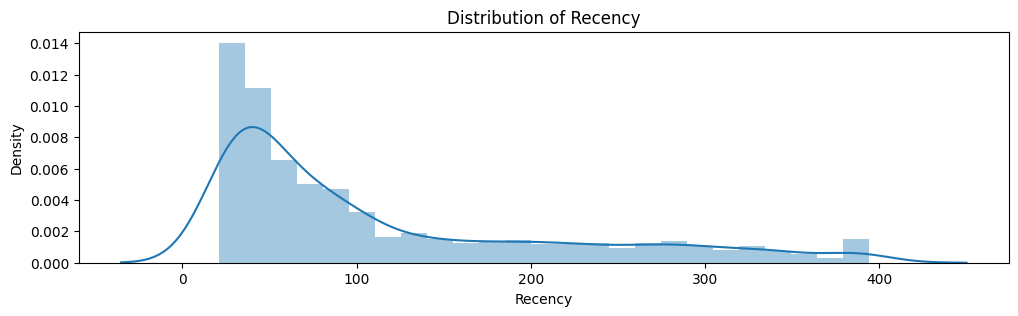

<ipython-input-8-791aecb21124>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(joined[col])


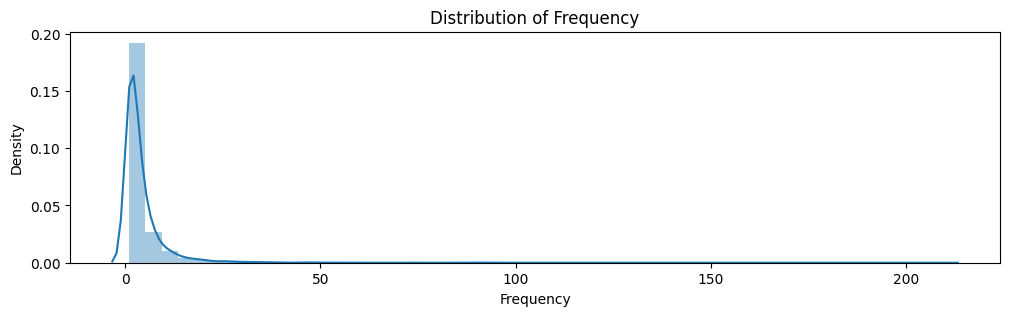

<ipython-input-8-791aecb21124>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(joined[col])


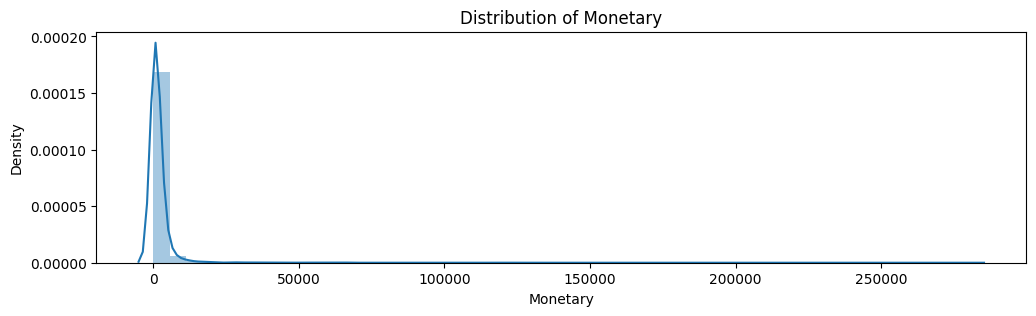

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
!pip install squarify
import squarify

#histogram
joined = pd.DataFrame(RFM_output_df)
colnames = ['Recency', 'Frequency', 'Monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(joined[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

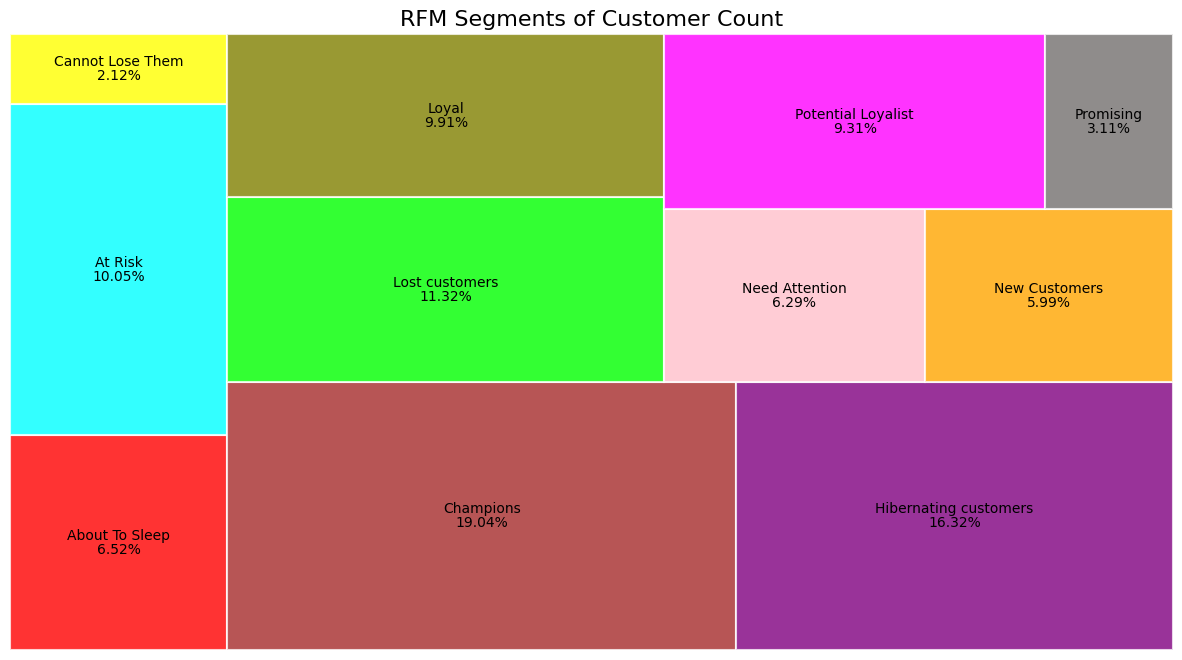

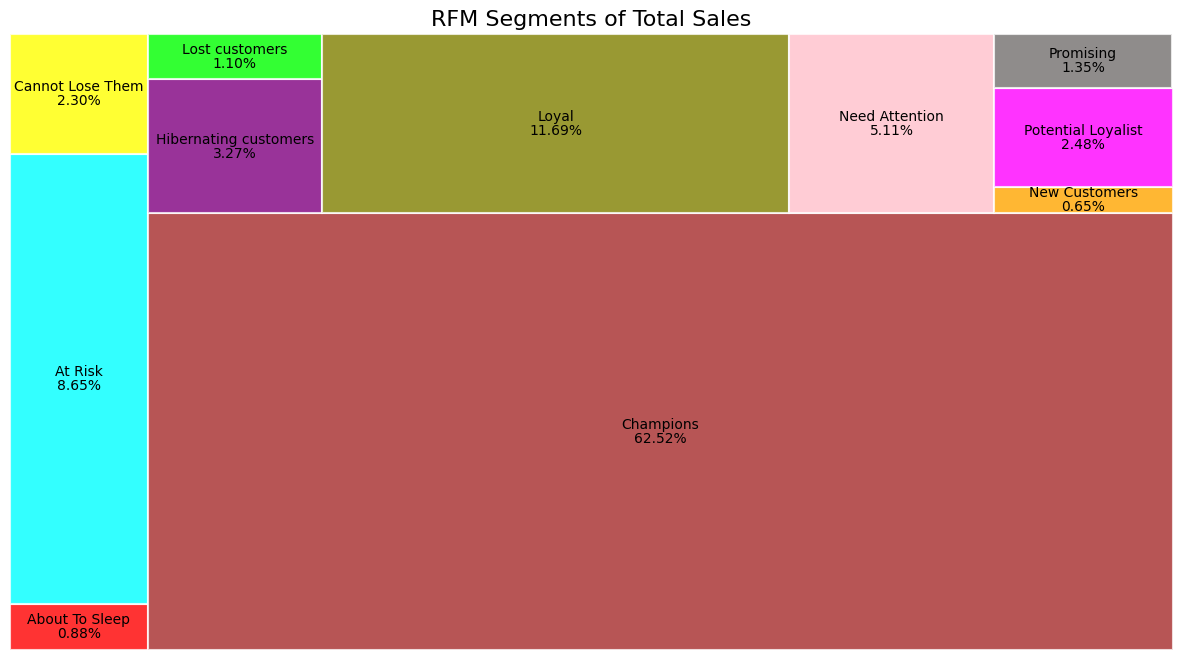

In [ ]:
#tree map
customer_counts = RFM_output_df.groupby('Segment')['CustomerID'].nunique().reset_index()
customer_counts.columns = ['Segment', 'Cust_count']
customer_counts['Count_share'] = customer_counts['Cust_count'] / customer_counts['Cust_count'].sum()

colors = ['#FF0000', '#00FFFF', '#FFFF00', '#A52A2A', '#800080', '#00FF00', '#808000', '#FFC0CB', '#FFA500', '#FF00FF', '#736F6E']

fig, ax = plt.subplots(1, figsize=(15,8))

squarify.plot(sizes=customer_counts['Cust_count'],
              label=customer_counts['Segment'],
              value=[f'{x*100:.2f}%' for x in customer_counts['Count_share']],
              alpha=.8,
              color=colors[:len(customer_counts)],
              bar_kwargs=dict(linewidth=1.5, edgecolor="white")
             )

plt.title('RFM Segments of Customer Count', fontsize=16)
plt.axis('off')
plt.show()

#segment by total sales
total_sales_by_segments = RFM_output_df.groupby('Segment')['Monetary'].sum().reset_index()
total_sales_by_segments.columns = ['Segment', 'Total Sales']
total_sales_by_segments['Sales_share'] = total_sales_by_segments['Total Sales'] / total_sales_by_segments['Total Sales'].sum()

colors = ['#FF0000', '#00FFFF', '#FFFF00', '#A52A2A', '#800080', '#00FF00', '#808000', '#FFC0CB', '#FFA500', '#FF00FF', '#736F6E']

fig, ax = plt.subplots(1, figsize=(15,8))

squarify.plot(sizes=total_sales_by_segments['Total Sales'],
              label=customer_counts['Segment'],
              value=[f'{x*100:.2f}%' for x in total_sales_by_segments['Sales_share']],
              alpha=.8,
              color=colors[:len(customer_counts)],
              bar_kwargs=dict(linewidth=1.5, edgecolor="white")
             )

plt.title('RFM Segments of Total Sales', fontsize=16)
plt.axis('off')
plt.show()

#insight and recommendation: https://www.canva.com/design/DAGHLeZB0Xw/V_ZbRkSNNy-3mVOV9GC60g/edit


